In [2]:
import os
import sys
import glob
from io import StringIO
import json
from collections import defaultdict
from tqdm import tqdm
from itertools import combinations
import numpy as np # Can't install NumPy 2.2.2 which is what the pkls were saved with
import pandas as pd # 'v2.2.3'
import anndata as ad
from joblib import delayed, Parallel

from scipy.spatial.distance import (
    pdist,
    squareform,
)
from pyexeggutor import (
    build_logger,
    write_pickle,
    read_pickle,
    write_json,
    read_json,
    read_list,
    check_argument_choice,
    format_header, 
)

from sklearn.metrics import (
    pairwise_distances,
    silhouette_score,
)
# from clairvoyance.utils import ( 
#     compile_parameter_space, # Can this be in Clairvoyance
# )
# from sklearn.cluster import (
#     HDBSCAN, # Not included in sklearn <1.3
# )
import ensemble_networkx as enx
import networkx as nx
import igraph as ig

import matplotlib.pyplot as plt

# Metabolic Niche Space
from metabolic_niche_space.utils import fast_groupby
from metabolic_niche_space.neighbors import (
    pairwise_distances_kneighbors,
    convert_distance_matrix_to_kneighbors_matrix,
)

import optuna
# from metabolic_niche_space.metabolic_niche_space.neighbors import 

%load_ext memory_profiler

/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 200)

In [140]:
# OpenAI
# !pip install dotenv
# from dotenv import load_dotenv
from openai import OpenAI

openai_api_key = open("/home/ec2-user/SageMaker/.openai").read().strip().split("=", maxsplit=1)[-1]

# client = OpenAI(
#   api_key=openai_api_key,
# )
client = OpenAI(
    api_key=openai_api_key,
    organization='org-Ez60DuNFqA22CtJjM2PpXQxa',
    project='proj_qCFyUKcDinIaUNIwuHRtNxpL',
)

# completion = client.chat.completions.create(
#   model="gpt-4o-mini",
#   store=True,
#   messages=[
#     {"role": "user", "content": "write a haiku about ai"}
#   ]
# )
# print(completion.choices[0].message)

def submit_openai_prompt(client, prompt, model="gpt-4o-mini", store=False):
    """
    Submits a prompt to the OpenAI API using the provided client and returns the response content as a string.
    
    Parameters:
        client: OpenAI client instance
            The initialized OpenAI client object.
        model: str
            The model to use for the completion (e.g., "gpt-4o-mini").
        prompt: str
            The user prompt to send to the OpenAI API.
        store: bool
            Whether to store the completion request (default is False).
    
    Returns:
        str: The content of the response from the OpenAI API.
    """
    try:
        # Submit the prompt to OpenAI
        completion = client.chat.completions.create(
            model=model,
            store=store,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        # Return the response content
        return completion.choices[0].message
    except Exception as e:
        # Handle exceptions and provide meaningful error messages
        print(f"An error occurred: {e}")
        return None


In [2]:
## ANI-Clusters
# genome_to_clusterani = pd.concat([
#     pd.read_csv("../data/cluster/ani/prokaryotic/completeness_gte90.contamination_lt5/genome_clusters.tsv", sep="\t", index_col=0, header=None).iloc[:,0],
#     pd.read_csv("../data/cluster/ani/eukaryotic/completeness_gte90.contamination_lt5/genome_clusters.tsv", sep="\t", index_col=0, header=None).iloc[:,0],
# ])
# genome_to_clusterani.index.name = "id_genome"
# genome_to_clusterani.name = "id_cluster-ani"

# genome_to_clusterani.to_csv(os.path.join(output_directory, "completeness_gte90.contamination_lt5", "genome_to_ani-cluster.tsv.gz"), sep="\t")

## Taxonomy
# data = list()

# for fp in glob.glob("/home/ec2-user/SageMaker/s3/newatlantis-genomics-db-prod/SourceDatabases/*/Metadata/taxonomy.tsv"):
#     try:
#         df = pd.read_csv(fp, sep="\t", index_col=0, header=None, comment="#")
#         data.append(df.iloc[:,0])
#     except (pd.errors.EmptyDataError, pd.errors.ParserError):
#         print(fp)
# genome_to_taxonomy = pd.concat(data)
# genome_to_taxonomy.index.name = "id_genome"
# genome_to_taxonomy.to_csv("../data/taxonomy.tsv.gz", sep="\t")

# # Assigning taxonomy to clusters without taxonomy scores
# clusterani_without_taxonomy = set()
# clusterani_to_taxonomy = dict()
# for id_clusterani, genomes in tqdm(genome_to_clusterani.groupby(genome_to_clusterani).groups.items()):
#     taxonomy = genome_to_taxonomy.loc[genomes.intersection(genome_to_taxonomy.index)]
#     if taxonomy.empty:
#         clusterani_without_taxonomy.add(id_clusterani)
#         clusterani_to_taxonomy[id_clusterani] = pd.NA
#     else:
#         value_counts = taxonomy.value_counts()
#         n_most_common = value_counts.max()
#         value_counts = value_counts[lambda v: v == n_most_common]
#         label = sorted(value_counts.index, key=len, reverse=True)[0]
#         clusterani_to_taxonomy[id_clusterani] = label
# clusterani_to_taxonomy = pd.Series(clusterani_to_taxonomy)
# clusterani_to_taxonomy.to_csv("../data/cluster/ani/cluster-ani_to_taxonomy.tsv.gz", sep="\t")

In [4]:
%%time
# Data
df_quality = pd.read_csv("../data/quality.tsv.gz",sep="\t", index_col=0)

quality_label="completeness_gte90.contamination_lt5"
# quality_label="completeness_gte50.contamination_lt10"
output_directory=f"../data/cluster/mfc/{quality_label}"
os.makedirs(output_directory, exist_ok=True)

genome_to_clusterani = pd.read_csv(f"../data/training/{quality_label}/y.tsv.gz", sep="\t", index_col=0, header=None).iloc[:,0].astype("category")
X_genomic_traits = pd.read_csv(f"../data/training/{quality_label}/X.tsv.gz", sep="\t", index_col=0).astype(bool)
X_genomic_traits_clusterani = pd.read_csv(f"../data/training/{quality_label}/X_grouped.tsv.gz", sep="\t", index_col=0).astype(bool)
eukaryotes = read_list(f"../data/cluster/ani/eukaryotic/{quality_label}/organisms.list", set)
prokaryotes = read_list(f"../data/cluster/ani/prokaryotic/{quality_label}/organisms.list", set)

genome_to_taxonomy = pd.read_csv("../data/taxonomy.tsv.gz", sep="\t", index_col=0).iloc[:,0]
clusterani_to_taxonomy = pd.read_csv("../data/cluster/ani/cluster-ani_to_taxonomy.tsv.gz", sep="\t", index_col=0, header=None).iloc[:,0]
df_meta_mfc__genomes = pd.read_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genomes.with_openai.tsv.gz", sep="\t", index_col=0)
df_meta_mfc__slc = pd.read_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genome_clusters.with_openai.tsv.gz", sep="\t", index_col=0)

X_genomic_traits_mfc = X_genomic_traits_clusterani.groupby(df_meta_mfc__slc["id_cluster-mfc"]).sum() > 0
df_kegg = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-raw-veba-db-prod/VDB_v8.1/Annotate/KOfam/kegg-ortholog_metadata.tsv", sep="\t", index_col=0)
ko_to_description = df_kegg["definition"]

print("Number of genomes: {}, Number of features: {}, Number of SLCs: {}".format(*X_genomic_traits.shape, X_genomic_traits_clusterani.shape[0]))
# Number of genomes: 20377, Number of features: 2124, Number of SLCs: 6719

# CPU times: user 3.41 s, sys: 87.8 ms, total: 3.5 s
# Wall time: 3.5 s

Number of genomes: 20377, Number of features: 2124, Number of SLCs: 6719
CPU times: user 4.69 s, sys: 321 ms, total: 5.01 s
Wall time: 5.46 s


In [80]:
%%memit
# %time jaccard_distances = pairwise_distances_kneighbors(X_genomic_traits_clusterani, metric="jaccard", n_jobs=-1)
# # CPU times: user 1h 4min 32s, sys: 32min, total: 1h 36min 32s
# # Wall time: 50min 23s


# %time jaccard_distances.to_pickle(f"{output_directory}/genomic_traits_clusterani.jaccard_distance.dataframe.pkl")
# # CPU times: user 0 ns, sys: 219 ms, total: 219 ms
# # Wall time: 215 ms
jaccard_distances = read_pickle(f"{output_directory}/genomic_traits_clusterani.jaccard_distance.dataframe.pkl")

peak memory: 1164.06 MiB, increment: 344.76 MiB


In [81]:
%%memit

n_neighbors = 15

#     # Convert distance matrix to non-redundant KNN
knn = convert_distance_matrix_to_kneighbors_matrix(jaccard_distances, n_neighbors=n_neighbors, redundant_form=False)
# CPU times: user 42.5 s, sys: 782 ms, total: 43.2 s
# Wall time: 43.2 s

#     # Remove disconnected nodes and convert to similarity
knn_similarity = 1 - knn[knn > 0]
# CPU times: user 13.7 s, sys: 0 ns, total: 13.7 s
# Wall time: 13.6 s

#     # Convert KNN to iGraph
graph = enx.convert_network(knn_similarity, ig.Graph)
# CPU times: user 41.7 s, sys: 444 µs, total: 41.7 s
# Wall time: 41.7 s

#     # Identify leiden communities using multiple seeds
df_communities = enx.community_detection(graph, n_iter=100, converge_iter=-1, n_jobs=1)
# CPU times: user 293 ms, sys: 3.14 s, total: 3.43 s
# Wall time: 4.25 s

#     # Identify membership co-occurrence ratios
node_pair_membership_cooccurrences = enx.community_membership_cooccurrence(df_communities).mean(axis=1)
# CPU times: user 1min 6s, sys: 3.66 s, total: 1min 10s
# Wall time: 1min 10s

#     # Identify node pairs that have co-membership 100% of the time
node_pairs_with_consistent_membership = set(node_pair_membership_cooccurrences[lambda x: x == 1.0].index)
# CPU times: user 13.4 s, sys: 325 ms, total: 13.8 s
# Wall time: 13.7 s

#     # Get list of clustered edges
clustered_edgelist = enx.get_undirected_igraph_edgelist_indices(graph, node_pairs_with_consistent_membership)
# CPU times: user 678 ms, sys: 3.88 ms, total: 682 ms
# Wall time: 680 ms

#     # Get clustered graph
graph_clustered = graph.subgraph_edges(clustered_edgelist, delete_vertices=True)
# CPU times: user 8.86 ms, sys: 45 µs, total: 8.9 ms
# Wall time: 8.89 ms

#     # Build MFC clusters based on Leiden communities
node_to_cluster = pd.Series(enx.get_undirected_igraph_connected_components(graph_clustered, cluster_prefix="MFC-"))

# Calculate silhouette scores
clustered_nodes = node_to_cluster.index
index = clustered_nodes.map(lambda x: jaccard_distances.index.get_loc(x)).values
dist = jaccard_distances.values[index,:][:,index]
score = silhouette_score(dist, node_to_cluster.values, metric="precomputed", sample_size=None, random_state=None) 
print(score)
# 0.18769024506772863

Community detection: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


0.1876902450677286
peak memory: 14834.20 MiB, increment: 13670.06 MiB


In [83]:
node_to_cluster.value_counts()
# MFC-1     414
# MFC-2     409
# MFC-3     326
# MFC-4     314
# MFC-5     309
#          ... 
# MFC-61     17
# MFC-62     15
# MFC-63      5
# MFC-64      4
# MFC-65      3
# Name: count, Length: 65, dtype: int64

MFC-1     414
MFC-2     409
MFC-3     326
MFC-4     314
MFC-5     309
         ... 
MFC-61     17
MFC-62     15
MFC-63      5
MFC-64      4
MFC-65      3
Name: count, Length: 65, dtype: int64

In [207]:
# Preview clusters
id_mfc = "MFC-52"
df = df_meta_mfc__genomes.loc[df_meta_mfc__genomes["id_cluster-mfc"].map(lambda x: x == id_mfc)]
print(df["taxonomy"].value_counts().iloc[:20].to_string())
df.iloc[0,-3:]

taxonomy
Eukaryota;Viridiplantae;-;Chlorophyta;Mamiellophyceae;-;Mamiellales;Bathycoccaceae;Ostreococcus sp- 'lucimarinus'                        10
d__Eukaryota;p__Chlorophyta;c__Trebouxiophyceae;o__Trebouxiales;f__Trebouxiaceae;g__Symbiochloris;s__Symbiochloris reticulata             5
d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Sphaeropleales;f__Scenedesmaceae;g__Tetradesmus;s__Tetradesmus obliquus                   4
Eukaryota;Viridiplantae;-;Chlorophyta;Mamiellophyceae;-;Mamiellales;Mamiellaceae;Micromonas pusilla                                       3
d__Eukaryota;p__Chlorophyta;c__Mamiellophyceae;o__Mamiellales;f__Bathycoccaceae;g__Ostreococcus;s__Ostreococcus tauri                     2
d__Eukaryota;p__Chlorophyta;c__Trebouxiophyceae;o__Chlorellales;f__Chlorellaceae;g__Auxenochlorella;s__Auxenochlorella protothecoides     2
d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Chlamydomonadales;f__Chlamydomonadaceae;g__Chlamydomonas;s__Chlamydomonas reinhardtii     2
d__Eukaryot

openai|gpt-4o-mini|enriched-taxa                                                                 Enriched in Chlorophyta, includes Ostreococcus, Micromonas, and Chlorella.
openai|gpt-4o-mini|metabolism-description            Known for photosynthesis, carbon fixation, and diverse metabolic pathways including lipid and carbohydrate metabolism.
openai|gpt-4o-mini|ecological-description    Occupies marine and freshwater ecosystems, contributes to primary production and nutrient cycling, while supporting food webs.
Name: Ostta1115_2, dtype: object

In [206]:
# Preview clusters
query = "Chlorophyceae" # ['MFC-17', 'MFC-27', 'MFC-50']
df = df_meta_mfc__genomes.loc[df_meta_mfc__genomes["taxonomy"].map(lambda x: query in str(x))]
df.loc[:,["id_cluster-ani", "taxonomy", "id_cluster-mfc"]]

,id_cluster-ani,taxonomy,id_cluster-mfc
id_genome,,,
Sceobl1450_1,NAL-ESLC_c024a186812da372b24e9af4a411cfd1,d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Sphaeropleales;f__Scenedesmaceae;g__Tetradesmus;s__Tetradesmus obliquus,MFC-52
Sceobl2630_1,NAL-ESLC_c024a186812da372b24e9af4a411cfd1,d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Sphaeropleales;f__Scenedesmaceae;g__Tetradesmus;s__Tetradesmus obliquus,MFC-52
SceoblDOE13_1,NAL-ESLC_c024a186812da372b24e9af4a411cfd1,d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Sphaeropleales;f__Scenedesmaceae;g__Tetradesmus;s__Tetradesmus obliquus,MFC-52
Scesp_1,NAL-ESLC_c7f26194ec93d2d6ea840c4313c92a62,d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Sphaeropleales;f__Scenedesmaceae;g__Scenedesmus;s__,MFC-52
Chlin1,NAL-ESLC_0f0457a3dd0c248fa5bf16bfdfdb215a,d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Chlamydomonadales;f__Chlamydomonadaceae;g__Chlamydomonas;s__Chlamydomonas incerta,MFC-52
Chlre5_6,NAL-ESLC_f61e13a694055602a5c72f2d3989c86a,d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Chlamydomonadales;f__Chlamydomonadaceae;g__Chlamydomonas;s__Chlamydomonas reinhardtii,MFC-52
ChlreiCC4532_1,NAL-ESLC_f61e13a694055602a5c72f2d3989c86a,d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Chlamydomonadales;f__Chlamydomonadaceae;g__Chlamydomonas;s__Chlamydomonas reinhardtii,MFC-52
Chlsc1,NAL-ESLC_e6c854979caa9cc44148a154e4bed33a,d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Chlamydomonadales;f__Chlamydomonadaceae;g__Chlamydomonas;s__Chlamydomonas schloesseri,MFC-52
Enacos1_1,NAL-ESLC_7a91c84648eb411eb56fa576d6a57758,d__Eukaryota;p__Chlorophyta;c__Chlorophyceae;o__Sphaeropleales;f__Scenedesmaceae;g__Enallax;s__Enallax costatus,MFC-52


In [137]:
 # ['MFC-17', 'MFC-27', 'MFC-50']
id_mfc = "MFC-50"
df = df_meta_mfc__genomes.loc[df_meta_mfc__genomes["id_cluster-mfc"].map(lambda x: x == id_mfc)]
print(df["taxonomy"].value_counts().iloc[:20].to_string())
# df["taxonomy"].value_counts().to_dict()


taxonomy
d__Bacteria;p__Desulfobacterota_D;c__UBA1144;o__UBA1144;f__UBA1144;g__TMED58;s__                                     11
d__Bacteria;p__Spirochaetota;c__Leptospirae;o__Leptospirales;f__Leptonemataceae;g__UBA3465;s__UBA3465 sp002730875    10
d__Bacteria;p__Desulfobacterota_D;c__UBA1144;o__UBA1144;f__UBA1144;g__TMED126;s__TMED126 sp002701605                  8
d__Bacteria;p__Desulfobacterota_D;c__UBA1144;o__UBA1144;f__UBA1144;g__TMED58;s__TMED58 sp002167555                    8
d__Bacteria;p__Spirochaetota;c__Leptospirae;o__Leptospirales;f__;g__;s__                                              7
d__Bacteria;p__Spirochaetota;c__Leptospirae;o__Leptospirales;f__Leptonemataceae;g__UBA3465;s__UBA3465 sp002729885     5
d__Bacteria;p__Desulfobacterota_D;c__UBA1144;o__UBA1144;f__UBA1144;g__GCA-002715585;s__GCA-002715585 sp002697665      5
d__Bacteria;p__Methylomirabilota;c__Methylomirabilia;o__Methylomirabilales;f__CSP1-5;g__CSP1-5;s__sp001643535         4
d__Bacteria;p__Methylomirabilot

Text(0, 0.5, 'Number of genomes')

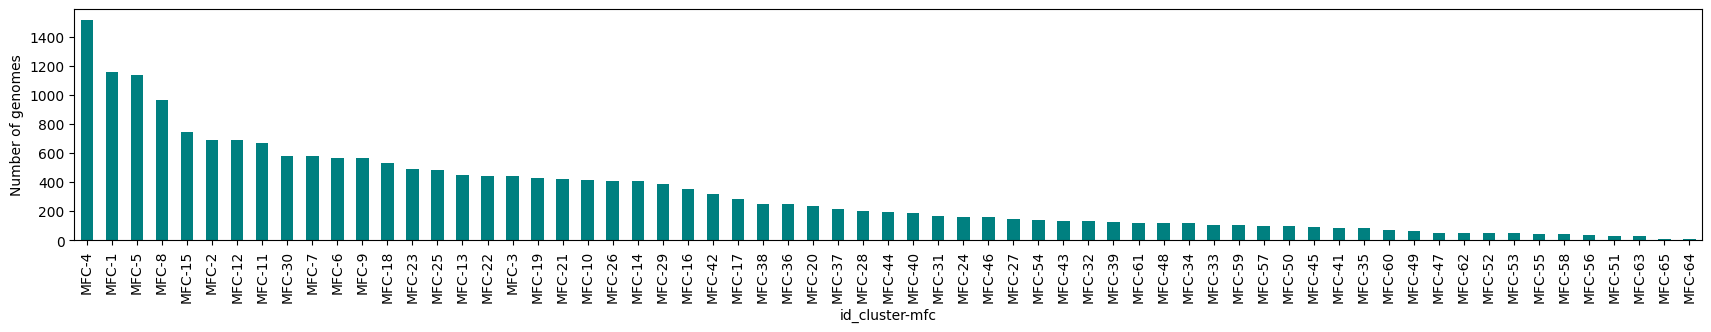

In [126]:
ax = df_meta_mfc__genomes["id_cluster-mfc"].value_counts().plot(kind="bar", color="teal", figsize=(21,3))
ax.set_ylabel("Number of genomes")

Text(0.5, 0, 'number of nodes')

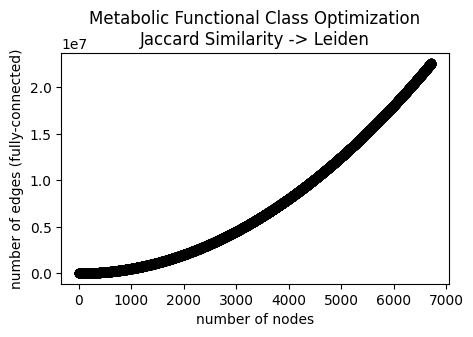

In [87]:
import numpy as np
u = pd.Series(np.arange(1,6719), np.arange(1,6719))
u = ((u**2 - u)*0.5).astype(int)

ax = u.plot(marker="o", color="black", figsize=(5,3))
ax.set_ylabel("number of edges (fully-connected)")
# ax.axvline(15, color="red")
ax.set_title("Metabolic Functional Class Optimization\nJaccard Similarity -> Leiden")
ax.set_xlabel("number of nodes")


Text(0.5, 1.0, 'Metabolic Functional Class Optimization\nJaccard Similarity -> Leiden')

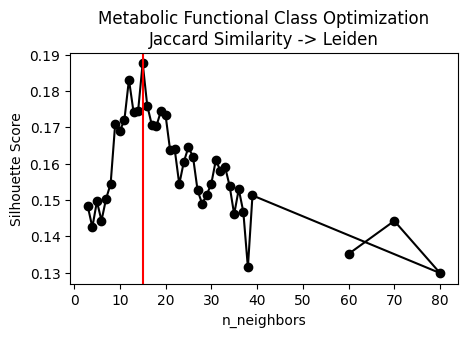

In [127]:
import pandas as pd
import re

# Log data as a multi-line string
log_data = """
2025-02-13 08:04:57,458 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 3] [score = 0.14827895414889997] [n_nodes = 6709] [n_edges = 15004
2025-02-13 08:08:56,462 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 4] [score = 0.14250146219957047] [n_nodes = 6704] [n_edges = 19737
2025-02-13 08:12:50,017 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 5] [score = 0.1496272928261032] [n_nodes = 6711] [n_edges = 24428
2025-02-13 08:16:54,362 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 6] [score = 0.14431727808225794] [n_nodes = 6715] [n_edges = 29105
2025-02-13 08:21:12,929 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 7] [score = 0.15032502410999418] [n_nodes = 6713] [n_edges = 33624
2025-02-13 08:25:37,678 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 8] [score = 0.1544862507691734] [n_nodes = 6710] [n_edges = 38336
2025-02-13 08:30:18,903 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 9] [score = 0.17105763725862652] [n_nodes = 6713] [n_edges = 42960
2025-02-13 08:34:52,962 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 10] [score = 0.169025490008705] [n_nodes = 6717] [n_edges = 47624
2025-02-13 08:39:49,783 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 11] [score = 0.17196930722711523] [n_nodes = 6715] [n_edges = 52129
2025-02-13 08:44:58,716 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 12] [score = 0.18315405021928527] [n_nodes = 6707] [n_edges = 56558
2025-02-13 08:50:17,413 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 13] [score = 0.17427951828168595] [n_nodes = 6712] [n_edges = 61221
2025-02-13 08:55:43,940 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 14] [score = 0.17447455334080886] [n_nodes = 6705] [n_edges = 65543
2025-02-13 09:01:38,520 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 15] [score = 0.1876902450677286] [n_nodes = 6710] [n_edges = 70196
2025-02-13 09:25:40,455 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 16] [score = 0.1759867529612348] [n_nodes = 6706] [n_edges = 74857]
2025-02-13 09:31:56,277 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 17] [score = 0.1706909386694163] [n_nodes = 6710] [n_edges = 79316]
2025-02-13 09:38:21,437 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 18] [score = 0.17033265772667766] [n_nodes = 6712] [n_edges = 83995]
2025-02-13 09:44:55,023 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 19] [score = 0.17455404626584417] [n_nodes = 6715] [n_edges = 88290]
2025-02-13 09:51:55,227 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 20] [score = 0.17340072924903233] [n_nodes = 6710] [n_edges = 92662]
2025-02-13 09:59:30,346 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 21] [score = 0.16371395246767542] [n_nodes = 6709] [n_edges = 96915]
2025-02-13 10:07:06,607 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 22] [score = 0.1639701260232878] [n_nodes = 6707] [n_edges = 100869]
2025-02-13 10:15:08,038 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 23] [score = 0.15434847225756584] [n_nodes = 6708] [n_edges = 105171]
2025-02-13 10:23:28,642 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 24] [score = 0.1605279453881246] [n_nodes = 6707] [n_edges = 109781]
2025-02-13 10:31:55,392 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 25] [score = 0.16453712198859935] [n_nodes = 6704] [n_edges = 114333]
2025-02-13 10:40:55,606 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 26] [score = 0.16191904797162412] [n_nodes = 6709] [n_edges = 118703]
2025-02-13 10:50:13,455 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 27] [score = 0.15271056758307056] [n_nodes = 6708] [n_edges = 123395]
2025-02-13 10:59:47,180 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 28] [score = 0.1489448709270961] [n_nodes = 6712] [n_edges = 127582]
2025-02-13 11:09:55,890 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 29] [score = 0.1514311625109161] [n_nodes = 6714] [n_edges = 131723]
2025-02-13 11:20:21,135 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 30] [score = 0.1544918014211842] [n_nodes = 6708] [n_edges = 135785]
2025-02-13 11:31:14,397 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 31] [score = 0.16102032824703968] [n_nodes = 6707] [n_edges = 139897]
2025-02-13 11:42:41,624 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 32] [score = 0.1580161985274517] [n_nodes = 6701] [n_edges = 144107]
2025-02-13 11:54:22,116 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 33] [score = 0.1591727464585174] [n_nodes = 6707] [n_edges = 148476]
2025-02-13 12:07:02,156 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 34] [score = 0.15392005845204768] [n_nodes = 6709] [n_edges = 152515]
2025-02-13 12:19:59,885 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 35] [score = 0.14606661123542003] [n_nodes = 6705] [n_edges = 156576]
2025-02-13 12:33:03,842 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 36] [score = 0.1529812796890363] [n_nodes = 6707] [n_edges = 160365]
2025-02-13 12:47:11,898 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 37] [score = 0.1467584872288237] [n_nodes = 6706] [n_edges = 164671]
2025-02-13 13:01:49,074 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 38] [score = 0.1314497736496415] [n_nodes = 6702] [n_edges = 169272]
2025-02-13 13:16:51,173 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 39] [score = 0.15127179177602582] [n_nodes = 6708] [n_edges = 172491]
2025-02-13 17:27:49,090 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 80] [score = 0.129897018080212] [n_nodes = 6712] [n_edges = 345257]
2025-02-13 18:06:05,019 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 70] [score = 0.14426080947656697] [n_nodes = 6712] [n_edges = 310227]
2025-02-13 18:36:23,740 - MetabolicFunctionalClass Detection - INFO - [n_neighbors = 60] [score = 0.1351558481997871] [n_nodes = 6711] [n_edges = 265089]
"""

# Updated regex pattern to tolerate missing closing brackets
pattern = r"\[n_neighbors = (\d+)\] \[score = ([0-9.]+)\] \[n_nodes = (\d+)\] \[n_edges = (\d+)"
data = []

for match in re.finditer(pattern, log_data):
    n_neighbors, score, n_nodes, n_edges = match.groups()
    data.append({
        "n_neighbors": int(n_neighbors),
        "score": float(score),
        "n_nodes": int(n_nodes),
        "n_edges": int(n_edges)
    })

# Convert to a DataFrame
df = pd.DataFrame(data).set_index("n_neighbors")
ax = df["score"].plot(marker="o", color="black", figsize=(5,3))
ax.set_ylabel("Silhouette Score")
ax.axvline(15, color="red")
ax.set_title("Metabolic Functional Class Optimization\nJaccard Similarity -> Leiden")


Text(0.5, 1.0, 'Metabolic Functional Class Optimization\nJaccard Similarity -> Leiden')

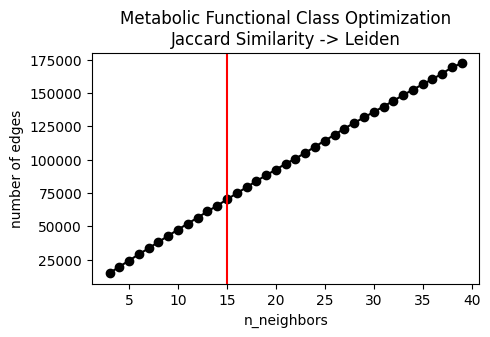

In [85]:
ax = df["n_edges"].plot(marker="o", color="black", figsize=(5,3))
ax.set_ylabel("number of edges")
ax.axvline(15, color="red")
ax.set_title("Metabolic Functional Class Optimization\nJaccard Similarity -> Leiden")


Text(0.5, 1.0, 'Metabolic Functional Class Optimization\nJaccard Similarity -> Leiden')

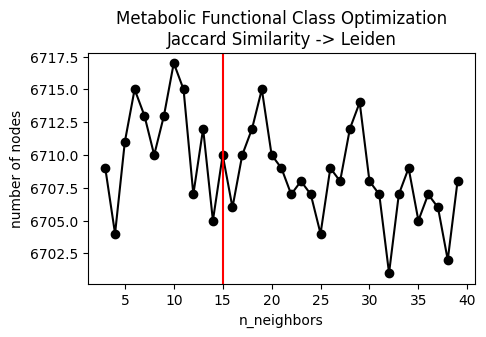

In [86]:
ax = df["n_nodes"].plot(marker="o", color="black", figsize=(5,3))
ax.set_ylabel("number of nodes")
ax.axvline(15, color="red")
ax.set_title("Metabolic Functional Class Optimization\nJaccard Similarity -> Leiden")


In [171]:
# # Annotating MFCs

# # mfc_to_response = dict()
# mfc_to_prompt = dict()
# for id_cluster_mfc, df in tqdm(df_meta_mfc__slc.groupby("id_cluster-mfc")):
#     taxa = df["taxonomy"].dropna().value_counts().to_dict()
#     prompt = "I have clustered prokaryotes and microeukaryotes by presence/absence of enzymes to yield Metabolic Functional Classes (MFC). " \
#              "For additional context, I have used jaccard similarity --> leiden community detection. " \
#              "Each MFC is exepected to contain groups of taxa that occupy similar metabolic niches in the environment. " \
#              "I need assistance in providing succinct descriptions about 1) what taxonomic groups are enriched in the MFC; 2) what metabolic" \
#              "functions this group of organisms is known for; and 3) what ecological niches this MFC may be occupying or ecosystem services this MFC may be providing. " \
#              "Please output a Python dictionary with the following keys: enriched_taxa, metabolic_niche_description, ecological_niche_description where values are the responses to the prompt. " \
#              "Instead of using terms like `This MFC is enriched in` use less words like `Enriched in`.  Instead of saying `The organisms in this MFC occupy` say `Occupies` this will make the responses more succinct. " \
#              "Please output the content without any additional text around it.  Please output the content without a variable name so I can load this into Python without parsing. "\
#              f"Here is the taxonomy for a MFC in a Python dict format where the key is a taxonomic lineage and the contains the number of genomes within the MFC:\n" \
#              f"{taxa}"
#     mfc_to_prompt[id_cluster_mfc] = prompt
#     # response = submit_openai_prompt(client, prompt)

#     # mfc_to_response[id_cluster_mfc] = response
# # 100%|██████████| 65/65 [02:14<00:00,  2.06s/it]
# # write_pickle(mfc_to_response, f"../data/cluster/mfc/{quality_label}/mfc_to_openai-response.dict.pkl")
# write_json(mfc_to_prompt, f"../data/cluster/mfc/{quality_label}/mfc_to_openai-prompt.json")

100%|██████████| 65/65 [00:00<00:00, 2132.50it/s]


In [6]:
# Annotating MFCs


mfc_to_info = dict()
for id_cluster_mfc, df in tqdm(df_meta_mfc__slc.groupby("id_cluster-mfc")):
    taxa = df["taxonomy"].dropna().value_counts().to_dict()
    kos = X_genomic_traits_mfc.columns[X_genomic_traits_mfc.loc[id_cluster_mfc]]
    kos = ko_to_description.loc[kos].dropna().to_dict()
    mfc_to_info[id_cluster_mfc] = {"taxonomy_count":taxa, "kegg_orthologs":kos}
write_json(mfc_to_info, f"../data/cluster/mfc/{quality_label}/mfc_to_info.json")

100%|██████████| 65/65 [00:00<00:00, 549.99it/s]


In [4]:
prompt = "I have clustered prokaryotes and microeukaryotes by presence/absence of enzymes to yield Metabolic Functional Classes (MFC). " \
         "For additional context, I have used jaccard similarity --> leiden community detection. " \
         "Each MFC is exepected to contain groups of taxa that occupy similar metabolic niches in the environment. " \
         "I need assistance in providing succinct descriptions about 1) what taxonomic groups are enriched in the MFC; 2) what metabolic" \
         "functions this group of organisms is known for; and 3) what ecological niches this MFC may be occupying or ecosystem services this MFC may be providing. " \
         "Please output a Python dictionary with the following keys: enriched_taxa, metabolic_niche_description, ecological_niche_description where values are the responses to the prompt. " \
         "Instead of using terms like `This MFC is enriched in` use less words like `Enriched in`.  Instead of saying `The organisms in this MFC occupy` say `Occupies` this will make the responses more succinct. " \
         "Please output the content without any additional text around it.  Please output the content without a variable name so I can load this into Python without parsing. "\
         f"Here is the taxonomy for a MFC in a Python dict format where the key is a taxonomic lineage and the contains the number of genomes within the MFC:\n" 
print(prompt)

I have clustered prokaryotes and microeukaryotes by presence/absence of enzymes to yield Metabolic Functional Classes (MFC). For additional context, I have used jaccard similarity --> leiden community detection. Each MFC is exepected to contain groups of taxa that occupy similar metabolic niches in the environment. I need assistance in providing succinct descriptions about 1) what taxonomic groups are enriched in the MFC; 2) what metabolicfunctions this group of organisms is known for; and 3) what ecological niches this MFC may be occupying or ecosystem services this MFC may be providing. Please output a Python dictionary with the following keys: enriched_taxa, metabolic_niche_description, ecological_niche_description where values are the responses to the prompt. Instead of using terms like `This MFC is enriched in` use less words like `Enriched in`.  Instead of saying `The organisms in this MFC occupy` say `Occupies` this will make the responses more succinct. Please output the conten

In [182]:
# Annotating MFCs


mfc_to_response = dict()
mfc_to_prompt = dict()
for id_cluster_mfc, df in tqdm(df_meta_mfc__slc.groupby("id_cluster-mfc")):
    taxa = df["taxonomy"].dropna().value_counts().to_dict()
    kos = X_genomic_traits_mfc.columns[X_genomic_traits_mfc.loc[id_cluster_mfc]]
    kos = ko_to_description.loc[kos].dropna().to_dict()
    prompt = "I have clustered prokaryotes and microeukaryotes by presence/absence of enzymes to yield Metabolic Functional Classes (MFC). " \
             "For additional context, I have used jaccard similarity --> leiden community detection. " \
             "Each MFC is exepected to contain groups of taxa that occupy similar metabolic niches in the environment. " \
             "I need assistance in providing succinct descriptions about 1) what taxonomic groups are enriched in the MFC; 2) what metabolic" \
             "functions this group of organisms is known for; and 3) what ecological niches this MFC may be occupying or ecosystem services this MFC may be providing. " \
             "Please output a Python dictionary with the following keys: enriched_taxa, metabolic_niche_description, ecological_niche_description where values are the responses to the prompt. " \
             "Instead of using terms like `This MFC is enriched in` use less words like `Enriched in`.  Instead of saying `The organisms in this MFC occupy` say `Occupies` this will make the responses more succinct. " \
             "Please output the content without any additional text around it.  Please output the content without a variable name so I can load this into Python without parsing. "\
             "Here is the taxonomy for a MFC in a Python dict format where the key is a taxonomic lineage and the contains the number of genomes within the MFC:\n" \
             f"{taxa}\n" \
             "Here is a Python dictionary of detected protein orthologs in the MFC where the key is a KEGG ortholog and value is the protein product description (including enzyme commission [EC] numbers when available) formatted: \n" \
             f"{kos}"
    response = submit_openai_prompt(client, prompt)
    mfc_to_response[id_cluster_mfc] = response
    mfc_to_prompt[id_cluster_mfc] = prompt
write_pickle(mfc_to_response, f"../data/cluster/mfc/{quality_label}/mfc_to_openai-response.with_kegg.dict.pkl")
write_json(mfc_to_prompt, f"../data/cluster/mfc/{quality_label}/mfc_to_openai-prompt.with_kegg.json")

100%|██████████| 65/65 [03:43<00:00,  3.44s/it]


In [188]:

mfc_to_description = dict()
for id_mfc, info in mfc_to_response.items():
    mfc_to_description[id_mfc] = json.load(StringIO(info.content))
df_mfc_description = pd.DataFrame(mfc_to_description).T
df_meta_mfc__genomes["openai|gpt-4o-mini|enriched-taxa"] = df_meta_mfc__genomes["id_cluster-mfc"].map(lambda x: mfc_to_description[x]["enriched_taxa"] if x in mfc_to_description else np.nan)
df_meta_mfc__genomes["openai|gpt-4o-mini|metabolism-description"] = df_meta_mfc__genomes["id_cluster-mfc"].map(lambda x: mfc_to_description[x]["metabolic_niche_description"] if x in mfc_to_description else np.nan)
df_meta_mfc__genomes["openai|gpt-4o-mini|ecological-description"] = df_meta_mfc__genomes["id_cluster-mfc"].map(lambda x: mfc_to_description[x]["ecological_niche_description"] if x in mfc_to_description else np.nan)
df_meta_mfc__genomes.to_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genomes.with_openai.tsv.gz", sep="\t")

df_meta_mfc__slc["openai|gpt-4o-mini|enriched-taxa"] = df_meta_mfc__slc["id_cluster-mfc"].map(lambda x: mfc_to_description[x]["enriched_taxa"] if x in mfc_to_description else np.nan)
df_meta_mfc__slc["openai|gpt-4o-mini|metabolism-description"] = df_meta_mfc__slc["id_cluster-mfc"].map(lambda x: mfc_to_description[x]["metabolic_niche_description"] if x in mfc_to_description else np.nan)
df_meta_mfc__slc["openai|gpt-4o-mini|ecological-description"] = df_meta_mfc__slc["id_cluster-mfc"].map(lambda x: mfc_to_description[x]["ecological_niche_description"] if x in mfc_to_description else np.nan)
df_meta_mfc__slc.to_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genome_clusters.with_openai.tsv.gz", sep="\t")



In [191]:
df_meta_mfc__slc.iloc[0]

taxonomy                                                                              d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae;g__;s__
id_cluster-mfc                                                                                                                                                          MFC-1
openai|gpt-4o-mini|enriched-taxa                                                                                              Bacteroidota, Acidobacteriota, Bdellovibrionota
openai|gpt-4o-mini|metabolism-description                                                    Known for metabolizing organic compounds, carbon cycling, and nitrogen fixation.
openai|gpt-4o-mini|ecological-description    Occupies marine and freshwater ecosystems, provides essential nutrients through organic matter degradation and nitrogen cycling.
Name: NAL-PSLC_014e8a57fc2dcfd95edce5f3d7e0bc7e, dtype: object

In [45]:

missing_taxonomy = set(genome_to_clusterani.index) - set(genome_to_taxonomy.index)

for fp in glob.glob("/home/ec2-user/SageMaker/s3/newatlantis-genomics-db-prod/SourceDatabases/*/organisms.*.list"):
    query = missing_taxonomy & read_list(fp, into=set)
    if query:
        print(fp.split("/")[-2])
        print("\t", query)
        print()
# Li_2024-PRJNA1111327-KermadecDiamantinaTrench
# 	 {'Kermadec_Trench_FDZ134_9415_24-26cm_bin.85', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.53', 'Kermadec_Trench_FDZ134_9415_0-2cm_bin.1', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.3', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.110', 'Kermadec_Trench_FDZ134_9415_28-30cm_bin.47', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.59', 'Kermadec_Trench_FDZ134_9415_24-26cm_bin.108', 'Kermadec_Trench_FDZ130_5861_8-10cm_bin.22', 'Kermadec_Trench_FDZ134_9415_24-26cm_bin.69', 'Kermadec_Trench_FDZ134_9415_28-30cm_bin.118', 'Kermadec_Trench_FDZ134_9415_28-30cm_bin.17', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.5'}

# TARA-BAC_ARC_MAGs
# 	 {'TARA_ANE_MAG_00001'}

# Zhang_2024-PRJNA113162029-YapMarianaTrenchSediment
# 	 {'SY223-base_bin17', 'SY223-base_bin14', 'SY206-sub_bin7', 'SY223-base_bin5', 'SY212-flank_bin6', 'SY220-base-sub_bin9'}



Li_2024-PRJNA1111327-KermadecDiamantinaTrench
	 {'Kermadec_Trench_FDZ134_9415_24-26cm_bin.85', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.53', 'Kermadec_Trench_FDZ134_9415_0-2cm_bin.1', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.3', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.110', 'Kermadec_Trench_FDZ134_9415_28-30cm_bin.47', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.59', 'Kermadec_Trench_FDZ134_9415_24-26cm_bin.108', 'Kermadec_Trench_FDZ130_5861_8-10cm_bin.22', 'Kermadec_Trench_FDZ134_9415_24-26cm_bin.69', 'Kermadec_Trench_FDZ134_9415_28-30cm_bin.118', 'Kermadec_Trench_FDZ134_9415_28-30cm_bin.17', 'Kermadec_Trench_FDZ134_9415_16-18cm_bin.5'}

TARA-BAC_ARC_MAGs
	 {'TARA_ANE_MAG_00001'}

Zhang_2024-PRJNA113162029-YapMarianaTrenchSediment
	 {'SY223-base_bin17', 'SY223-base_bin14', 'SY206-sub_bin7', 'SY223-base_bin5', 'SY212-flank_bin6', 'SY220-base-sub_bin9'}



In [124]:
# # Assigning taxonomy to clusters without taxonomy scores
# clusterani_without_taxonomy = set()
# clusterani_to_taxonomy = dict()
# for id_clusterani, genomes in tqdm(genome_to_clusterani.groupby(genome_to_clusterani).groups.items()):
#     taxonomy = genome_to_taxonomy.loc[genomes.intersection(genome_to_taxonomy.index)]
#     if taxonomy.empty:
#         clusterani_without_taxonomy.add(id_clusterani)
#         clusterani_to_taxonomy[id_clusterani] = pd.NA
#     else:
#         value_counts = taxonomy.value_counts()
#         n_most_common = value_counts.max()
#         value_counts = value_counts[lambda v: v == n_most_common]
#         label = sorted(value_counts.index, key=len, reverse=True)[0]
#         clusterani_to_taxonomy[id_clusterani] = label
# clusterani_to_taxonomy = pd.Series(clusterani_to_taxonomy)


# df_mfc = clusterani_to_taxonomy.to_frame("taxonomy")
# df_mfc.index.name = "id_cluster-ani"
# df_mfc["id_cluster-mfc"] = node_to_cluster.reindex(df_mfc.index)
# index = list(map(lambda x: x[0], sorted(df_mfc["id_cluster-mfc"].items(), key=lambda x: np.nan if not isinstance(x[1], str) else int(x[1].split("-")[-1]))))
# df_mfc = df_mfc.loc[index]
# df_mfc.to_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.tsv.gz", sep="\t")

# df_mfc

,taxonomy,id_cluster-mfc
id_cluster-ani,,
NAL-PSLC_014e8a57fc2dcfd95edce5f3d7e0bc7e,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,MFC-1
NAL-PSLC_017564e37cb813c7c06aa83178eea5db,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,MFC-1
NAL-PSLC_02bd22c795fb63fdff41d099e83d9046,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,MFC-1
NAL-PSLC_02d8717e9eab0cf9e14f34c69893cf01,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,MFC-1
NAL-PSLC_031d83494875744ae301c870cbbb752c,d__Bacteria;p__Bacteroidota;c__Flavobacteriia;...,MFC-1
...,...,...
NAL-PSLC_cf7886b6ed3dfd25ee4cacca4f7fe10e,d__Bacteria;p__SAR324;c__SAR324;o__SAR324;f__N...,MFC-62
NAL-PSLC_e3159b4ef3773fca52a3be3ea1000774,d__Bacteria;p__SAR324;c__SAR324;o__SAR324;f__N...,MFC-62
NAL-PSLC_eef4495d6089179331feede261956df9,d__Bacteria;p__;c__Deltaproteobacteria;o__;f__...,MFC-62


In [121]:
# print(df_mfc.loc[df_mfc["id_cluster-mfc"] == 'MFC-4']["taxonomy"].value_counts().to_string())
# list(df_mfc.loc[df_mfc["id_cluster-mfc"] == 'MFC-2']["taxonomy"].value_counts().index)

df_mfc.loc[df_mfc["taxonomy"].map(lambda x: "Cyano" in str(x))].iloc[1]["taxonomy"]

'd__Bacteria;p__Cyanobacteria;c__Vampirovibrionia;o__Vampirovibrionales;f__Vampirovibrionaceae;g__;s__'

In [146]:
# # MFC wrt genome
# df_meta_genomes = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-genomics-db-prod/Metadata/genome_data.tsv", sep="\t", index_col=0)
# df_mfc_wrt_genomes = genome_to_clusterani.to_frame("id_cluster-ani")
# df_mfc_wrt_genomes = pd.merge(df_mfc_wrt_genomes, df_mfc, left_on="id_cluster-ani", right_index=True)
# df_mfc_wrt_genomes = pd.concat([
#     df_mfc_wrt_genomes, 
#     df_meta_genomes.loc[df_mfc_wrt_genomes.index],
#     df_quality[["completeness", "contamination"]].loc[df_mfc_wrt_genomes.index],

# ], axis=1)
# index = list(map(lambda x: x[0], sorted(df_mfc_wrt_genomes["id_cluster-mfc"].items(), key=lambda x: np.nan if not isinstance(x[1], str) else int(x[1].split("-")[-1]))))
# df_mfc_wrt_genomes = df_mfc_wrt_genomes.loc[index]

# df_mfc_wrt_genomes.index.name = "id_genome"
# # df_mfc_wrt_genomes.to_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genomes.tsv.gz", sep="\t")

In [149]:
df_meta_genomes["database"].value_counts()

database
OceanDNA                                                     52325
TARA-TOPAZ                                                    4707
JGI-MycoCosm                                                  2441
TARA-BAC_ARC_MAGs                                             1888
Xu_2024-PRJNA880762-SouthChinaSea                             1887
EnsemblFungi                                                  1501
Liu_2024-PRJNA1081583-EastChinaSeaLowOxygenRegion             1498
Li_2024-PRJNA1111327-KermadecDiamantinaTrench                 1263
Zhang_2022-PRJNA707313-ColdSeepSouthChinaSea                   768
TARA-SMAGv1                                                    711
Zhou_2022-PRJNA730330-SouthChinaEstuary                        500
MMP-MarRef                                                     451
TARA-Delmont_2018                                              434
Nathani_2021-PRJEB26614_PRJEB26615-GulfKuthiawarPeninsula      311
EnsemblProtists                                      

Text(0.5, 0, 'number of nodes')

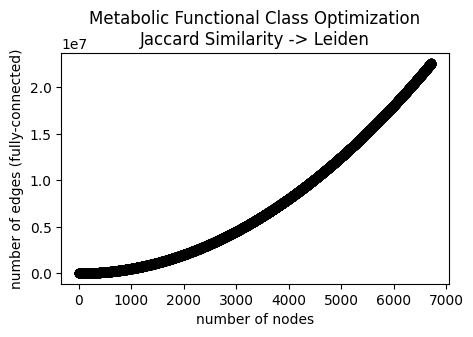

In [6]:
# %time convert_distance_matrix_to_kneighbors_matrix(jaccard_distances, n_neighbors=10, redundant_form=False)
# # peak memory: 6672.78 MiB, increment: 5569.32 MiB
# # CPU times: user 33.1 s, sys: 2.44 s, total: 35.5 s
# # Wall time: 35.5 s
# %time convert_distance_matrix_to_kneighbors_matrix(jaccard_distances, n_neighbors=100, redundant_form=False)
# # peak memory: 22435.10 MiB, increment: 5581.41 MiB
# # CPU times: user 32.7 s, sys: 2.5 s, total: 35.2 s
# # Wall time: 35.1 s

In [113]:
# %%memit
# ======================
# NOTE: This was not useful using Optuna.  Much faster to run iteratively and with fewer resources.  Just make sure not to use n_jobs=-1 for leiden with parallelbackend as threading
# =====================
# study_name = "MetabolicFunctionalClass Detection"
# logger = build_logger(study_name)
# param_history = defaultdict(set)

# def objective(trial):
#     n = jaccard_distances.shape[0]
    
#     low = int(np.log(n))
#     high = int(np.sqrt(n))

#     # Parameters to tune
#     while True:
#         n_neighbors = trial.suggest_int("n_neighbors", low, high)
#         if n_neighbors not in param_history["n_neighbors"]:
#             param_history["n_neighbors"].add(n_neighbors)
#             break
#         else:
#             # Log the redundancy for debugging or informational purposes
#             logger.warning(f"[Trial {trial.number}] Redundant parameter {n_neighbors} detected. Retrying...")

#     # Convert distance matrix to non-redundant KNN
#     logger.info(f"[Trial {trial.number}] Convert distance matrix to non-redundant KNN (n_neighbors = {n_neighbors})")
#     knn = convert_distance_matrix_to_kneighbors_matrix(jaccard_distances, n_neighbors=n_neighbors, redundant_form=False)
    
#     # Remove disconnected nodes and convert to similarity
#     logger.info(f"[Trial {trial.number}] Remove disconnected nodes and convert to similarity (n_neighbors = {n_neighbors})")
#     knn_similarity = 1 - knn[knn > 0]

#     # Convert KNN to iGraph
#     logger.info(f"[Trial {trial.number}] Convert KNN to iGraph (n_neighbors = {n_neighbors})")
#     graph = enx.convert_network(knn_similarity, ig.Graph)

#     # Identify leiden communities with multiple seeds
#     logger.info(f"[Trial {trial.number}] Identify leiden communities with multiple seeds (n_neighbors = {n_neighbors})")
#     progressbar_message = f"[Trial {trial.number}] Community detection (n_neighbors = {n_neighbors})"
#     df_communities = enx.community_detection(graph, n_iter=100, converge_iter=25, n_jobs=-1, progressbar_message=progressbar_message)
    
#     # Identify membership co-occurrence ratios
#     logger.info(f"[Trial {trial.number}] Identify membership co-occurrence ratios (n_neighbors = {n_neighbors})")
#     node_pair_membership_cooccurrences = enx.community_membership_cooccurrence(df_communities).mean(axis=1)
    
#     # Identify node pairs that have co-membership 100% of the time
#     node_pairs_with_consistent_membership = set(node_pair_membership_cooccurrences[lambda x: x == 1.0].index)

#     # Get list of clustered edges
#     clustered_edgelist = enx.get_undirected_igraph_edgelist_indices(graph, node_pairs_with_consistent_membership)
    
#     # Get clustered graph
#     graph_clustered = graph.subgraph_edges(clustered_edgelist, delete_vertices=True)
    
#     # Clusters
#     node_to_cluster = pd.Series(enx.get_undirected_igraph_connected_components(graph_clustered))
    
    
#     # Calculate silhouette scores
#     clustered_nodes = node_to_cluster.index
#     index = clustered_nodes.map(lambda x: jaccard_distances.index.get_loc(x)).values
#     logger.info(f"[Trial {trial.number}] Calculate silhouette scores using {len(index)} nodes (n_neighbors = {n_neighbors})")
#     dist = jaccard_distances.values[index,:][:,index]
#     score = silhouette_score(dist, node_to_cluster.values, metric="precomputed", sample_size=None, random_state=None) 

#     return score




# sampler = optuna.samplers.TPESampler(seed=0)

# # Study
# study_kws=dict()
# study_params = {
#     "direction":"maximize", 
#     "study_name":study_name, 
#     "sampler":sampler, 
#     **study_kws,
# }


# study = optuna.create_study(**study_params)

# # Optimize
# # To optimize resource usage, calculate the total memory needed for each job, then calculate how long it takes for each job
# # If my machine has 128GB of memory, each job takes 10GB of memory, 5 minutes to run and I want at least 6 trials then I would do:
# # * 25 n_jobs, 6*25 = 150 trials, which I would expect to take 5*6 = 30 minutes
# study.optimize(
#     objective, 
#     n_trials=32, # This should be dependent on time
#     n_jobs=8, # This should maximize the amount of resources that are used
#     # timeout=self.study_timeout, 
#     show_progress_bar=True, 
#     # callbacks=self.study_callbacks + [_stop_when_exceeding_trials], 
#     gc_after_trial=True,
# )
# # 31257 ec2-user  20   0   74.5g  69.2g 130228 S 100.7 37.5  87:12.02 python                                                                                                                             

In [ ]:
# [I 2025-02-12 00:01:41,225] A new study created in memory with name: MetabolicFunctionalClass Detection
#   0%|          | 0/10 [00:00<?, ?it/s]
# 2025-02-12 00:01:41,232 - MetabolicFunctionalClass Detection - INFO - [Trial 0] Convert distance matrix to non-redundant KNN (n_neighbors = 62)
# 2025-02-12 00:01:41,233 - MetabolicFunctionalClass Detection - INFO - [Trial 1] Convert distance matrix to non-redundant KNN (n_neighbors = 72)
# 2025-02-12 00:01:41,235 - MetabolicFunctionalClass Detection - INFO - [Trial 2] Convert distance matrix to non-redundant KNN (n_neighbors = 75)
# 2025-02-12 00:01:41,236 - MetabolicFunctionalClass Detection - INFO - [Trial 3] Convert distance matrix to non-redundant KNN (n_neighbors = 11)
# 2025-02-12 00:02:26,236 - MetabolicFunctionalClass Detection - INFO - [Trial 0] Remove disconnected nodes and convert to similarity (n_neighbors = 62)
# 2025-02-12 00:02:44,457 - MetabolicFunctionalClass Detection - INFO - [Trial 3] Remove disconnected nodes and convert to similarity (n_neighbors = 11)
# 2025-02-12 00:02:45,051 - MetabolicFunctionalClass Detection - INFO - [Trial 2] Remove disconnected nodes and convert to similarity (n_neighbors = 75)
# 2025-02-12 00:02:58,434 - MetabolicFunctionalClass Detection - INFO - [Trial 0] Convert KNN to iGraph (n_neighbors = 62)
# 2025-02-12 00:03:25,019 - MetabolicFunctionalClass Detection - INFO - [Trial 3] Convert KNN to iGraph (n_neighbors = 11)
# 2025-02-12 00:03:25,114 - MetabolicFunctionalClass Detection - INFO - [Trial 2] Convert KNN to iGraph (n_neighbors = 75)
# 2025-02-12 00:04:23,490 - MetabolicFunctionalClass Detection - INFO - [Trial 1] Remove disconnected nodes and convert to similarity (n_neighbors = 72)
# 2025-02-12 00:04:36,934 - MetabolicFunctionalClass Detection - INFO - [Trial 1] Convert KNN to iGraph (n_neighbors = 72)
# 2025-02-12 00:07:17,953 - MetabolicFunctionalClass Detection - INFO - [Trial 3] Identify leiden communties with multiple seeds (n_neighbors = 11)
# 2025-02-12 00:08:32,896 - MetabolicFunctionalClass Detection - INFO - [Trial 3] Identify membership co-occurrence ratios (n_neighbors = 11)
# 2025-02-12 00:12:09,372 - MetabolicFunctionalClass Detection - INFO - [Trial 3] Calculate silhouette scores using 6708 nodes (n_neighbors = 11)
                                      
# [W 2025-02-12 00:12:09,539] Trial 3 failed with parameters: {'n_neighbors': 11} because of the following error: ValueError('Expected 2D array, got 1D array instead:\narray=[0. 0. 0. ... 0. 0. 0.].\nReshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.').
# Traceback (most recent call last):
#   File "/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
#     value_or_values = func(trial)
#   File "<string>", line 50, in objective
#   File "/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/sklearn/metrics/cluster/_unsupervised.py", line 117, in silhouette_score
#     return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
#   File "/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/sklearn/metrics/cluster/_unsupervised.py", line 212, in silhouette_samples
#     X, labels = check_X_y(X, labels, accept_sparse=["csc", "csr"])
#   File "/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1106, in check_X_y
#     X = check_array(
#   File "/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/sklearn/utils/validation.py", line 902, in check_array
#     raise ValueError(
# ValueError: Expected 2D array, got 1D array instead:
# array=[0. 0. 0. ... 0. 0. 0.].
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
#   0%|          | 0/10 [10:29<?, ?it/s]
# [W 2025-02-12 00:12:10,367] Trial 3 failed with value None.

In [ ]:
# def pairwise_cosine(X, similarity=False, into=pd.Series, **kws):
#     values = pdist(X.values, metric="cosine")
#     if similarity:
#         values = 1 - values
#     if into == pd.Series:
#         index = list(map(frozenset, combinations(X.index, 2)))
#         return pd.Series(values, index=index, **kws)
#     elif into == nx.Graph:
#         graph = nx.Graph(metric="cosine", similarity=similarity, **kws)
#         for (node_a, node_b),v in zip(combinations(X.index, 2), values):
#             graph.add_edge(node_a, node_b, weight=v)
#         return graph
#     elif into == ig.Graph:
#         graph = ig.Graph()
#         # Add nodes
#         graph.add_vertices(X.index.tolist())  # Ensure nodes retain original labels

#         # Add edges with weights
#         edges = list(combinations(X.index, 2))  # Generate all possible node pairs
#         graph.add_edges(edges)  # Add edges
#         graph.es["weight"] = values  # Assign weights
#         return graph


In [ ]:
# import numpy as np
# import pandas as pd
# import igraph as ig
# import optuna
# from sklearn.metrics import silhouette_score
# from itertools import product
# from leidenalg import find_partition, ModularityVertexPartition

# def leiden_community_detection(graph: ig.Graph, n_iter: int = 10, weight: str = "weight", resolution: float = 1.0):
#     """
#     Runs Leiden community detection multiple times with different random seeds
#     to identify consistent community assignments.

#     Parameters:
#     -----------
#     graph : igraph.Graph
#         The igraph object containing the nodes and weighted edges.
#     n_iter : int
#         Number of random seeds to run.
#     weight : str
#         Edge weight attribute in the graph.
#     resolution : float
#         Leiden resolution parameter.

#     Returns:
#     --------
#     pd.DataFrame
#         A DataFrame where rows are nodes and columns are different random seeds,
#         with values indicating cluster membership.
#     """
#     node_ids = np.array(graph.vs["name"])  # Extract node names
#     partitions = {}

#     for seed in range(n_iter):
#         partition = find_partition(
#             graph,
#             ModularityVertexPartition,
#             weights=weight,
#             seed=seed,
#             resolution_parameter=resolution,
#             n_iterations=-1,
#         )
#         node_to_cluster = {node_ids[n]: c for c, nodes in enumerate(partition) for n in nodes}
#         partitions[seed] = pd.Series(node_to_cluster)

#     return pd.DataFrame(partitions)  # Transpose to have nodes as rows

In [ ]:
# def get_undirected_igraph_edgelist_indices(graph, edge_list):
#     name_to_index = {name: idx for idx, name in enumerate(graph.vs["name"])}

#     edgelist_indices = list()
#     for node_a, node_b in map(list, edge_list):
#         node_a_index = name_to_index[node_a]
#         node_b_index = name_to_index[node_b]
#         if graph.are_adjacent(node_a_index, node_b_index):
#             edge_index = graph.get_eid(node_a_index, node_b_index, directed=False)
#             edge = graph.es[edge_index]
#             edgelist_indices.append(edge)
#     return edgelist_indices
    
# def get_undirected_igraph_connected_components(graph, cluster_prefix="c", return_mode="nodes"):
#     if isinstance(return_mode, tuple):
#         return_mode = tuple(sorted(return_mode))
        
#     check_argument_choice(return_mode, {"nodes", "clusters", ("clusters","nodes")})
        
#     components = enumerate(sorted(graph.connected_components(), key=len, reverse=True), start=1)
    
#     if return_mode == "nodes":
#         node_to_cluster = {}

#         for i, nodes in components:
#             id_cluster = f"{cluster_prefix}{i}"
#             node_names = {graph.vs[node]["name"] for node in nodes}  # Get node names in the cluster
#             for n in node_names:
#                 node_to_cluster[n] = id_cluster
#         return node_to_cluster
    
#     elif return_mode == "clusters":
#         cluster_to_nodes = {}
#         for i, nodes in components:
#             id_cluster = f"{cluster_prefix}{i}"
#             node_names = {graph.vs[node]["name"] for node in nodes}  # Get node names in the cluster
#             cluster_to_nodes[id_cluster] = node_names
#         return cluster_to_nodes
    
#     elif return_mode == ("clusters","nodes"):
#         node_to_cluster = {}
#         cluster_to_nodes = {}

#         for i, nodes in components:
#             id_cluster = f"{cluster_prefix}{i}"
#             node_names = {graph.vs[node]["name"] for node in nodes}  # Get node names in the cluster
#             cluster_to_nodes[id_cluster] = node_names
#             for n in node_names:
#                 node_to_cluster[n] = id_cluster
#         return cluster_to_nodes, node_to_cluster

In [ ]:

# def objective(trial):
#     n = jaccard_distances.shape[0]
    
#     low = int(np.log(n))
#     high = int(np.sqrt(n))

#     # Parameters to tune
#     n_neighbors = trial.suggest_int("n_neighbors", low, high)
#     if n_neighbors not in param_history["n_neighbors"]:
#         param_history["n_neighbors"].add(n_neighbors)
#     else:
#         # ADD CODE HERE
#         # PLEASE SELECT A PARAMATER THAT IS NOT IN PARAM_HISTORY AND THEN UPDATE THE DICTIONARY
#         # ADD CODE HERE

#     # Convert distance matrix to non-redundant KNN
#     logger.info(f"[Trial {trial.number}] Convert distance matrix to non-redundant KNN (n_neighbors = {n_neighbors})")
#     knn = convert_distance_matrix_to_kneighbors_matrix(jaccard_distances, n_neighbors=n_neighbors, redundant_form=False)
    
#     # Remove disconnected nodes and convert to similarity
#     logger.info(f"[Trial {trial.number}] Remove disconnected nodes and convert to similarity (n_neighbors = {n_neighbors})")
#     knn_similarity = 1 - knn[knn > 0]

#     # Convert KNN to iGraph
#     logger.info(f"[Trial {trial.number}] Convert KNN to iGraph (n_neighbors = {n_neighbors})")
#     graph = enx.convert_network(knn_similarity, ig.Graph)

#     # Identify leiden communties with multiple seeds
#     logger.info(f"[Trial {trial.number}] Identify leiden communties with multiple seeds (n_neighbors = {n_neighbors})")
#     progressbar_message = f"[Trial {trial.number}] Community detection (n_neighbors = {n_neighbors})"
#     df_communities = community_detection(graph, n_iter=100, converge_iter=25, n_jobs=-1, progressbar_message=progressbar_message)
    
#     # Identify membership co-occurrence ratios
#     logger.info(f"[Trial {trial.number}] Identify membership co-occurrence ratios (n_neighbors = {n_neighbors})")
#     node_pair_membership_cooccurrences = enx.community_membership_cooccurrence(df_communities).mean(axis=1)
    
#     # Identify node pairs that have co-membership 100% of the time
#     node_pairs_with_consistent_membership = set(node_pair_membership_cooccurrences[lambda x: x == 1.0].index)

#     # Get list of clustered edges
#     clustered_edgelist = enx.get_undirected_igraph_edgelist_indices(graph, node_pairs_with_consistent_membership)
    
#     # Get clustered graph
#     graph_clustered = graph.subgraph_edges(clustered_edgelist, delete_vertices=True)
    
#     # Clusters
#     node_to_cluster = pd.Series(enx.get_undirected_igraph_connected_components(graph_clustered))
    
    
#     # Calculate silhouette scores
#     clustered_nodes = node_to_cluster.index
#     index = clustered_nodes.map(lambda x: jaccard_distances.index.get_loc(x)).values
#     logger.info(f"[Trial {trial.number}] Calculate silhouette scores using {len(index)} nodes (n_neighbors = {n_neighbors})")
#     dist = jaccard_distances.values[index,:][:,index]
#     score = silhouette_score(dist, node_to_cluster.values, metric="precomputed", sample_size=None, random_state=None) 

#     return score

In [ ]:
# df_ncbi = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-genomics-db-prod/NCBITaxonomy/ncbi_accessions.tsv.gz", sep="\t", index_col=0, usecols=[0,6])

# oldid_to_taxonomy = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-genomics-db-prod/SourceDatabases/Zhang_2023-PRJNA808646-CCFZ/Metadata/tmp/taxonomy.tsv", sep="\t", index_col=0, header=None).iloc[:,0]

# df_meta = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-genomics-db-prod/SourceDatabases/Zhang_2023-PRJNA808646-CCFZ/Metadata/metadata.genomes.tsv.gz", sep="\t", index_col=0)
# df_meta["taxid"] = df_meta["taxid"].map(str)
# output = df_meta["isolate"].map(lambda x: oldid_to_taxonomy[x])
# output.index.name = "# GTDB_r95"
# output.name = None
# output.to_csv("test.tsv", sep="\t")
# # df_taxonkit = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-genomics-db-prod/SourceDatabases/Zhang_2023-PRJNA808646-CCFZ/Metadata/id_to_taxid.taxonkit.tsv", sep="\t", header=None, index_col=0)
# # df_taxonkit.index = df_taxonkit.index.map(str)
# # pd.merge(df_meta, df_taxonkit, right_index=True, left_on="taxid")[3]
